In [1]:
import torch
import catboost
from torch import nn
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier
import gc
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset,DataLoader
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings 
warnings.filterwarnings('ignore')

In [2]:
def backbone(self, x):
    x = self.module.conv1(x)
    x = self.module.bn1(x)
    x = self.module.relu(x)

    x = self.module.layer1(x)
    x = self.module.layer2(x)
    x = self.module.layer3(x)

    return x

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path).iloc[:,:]
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

def load_pretrain_senet(model_path):
    model = torch.hub.load(
        'moskomule/senet.pytorch',
        'se_resnet20',
        num_classes=6)
    model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.backbone = backbone.__get__(model)
    return model

def get_senet_output(senet,data):
    return senet(data)

def get_all_senet_output(data):
    y = senet(data)
    return y.detach().cpu().numpy()

def get_X_numpy(X):
    X_train_np = np.array([[]])
    data_iter = DataLoader(TensorDataset(torch.FloatTensor(X.to(torch.float32))),batch_size=256)
    for bx in tqdm(data_iter):
        bx = bx[0]
        bx = bx.to('cuda:0')
        y_hat = get_all_senet_output(bx)
        if len(X_train_np) == 1:
            X_train_np = y_hat
        else:
            X_train_np = np.vstack((X_train_np,y_hat))
    return X_train_np

def get_X_numpy_backbone(X):
    X_train_np = np.array([[]])
    data_iter = DataLoader(TensorDataset(torch.FloatTensor(X.to(torch.float32))),batch_size=64)
    for bx in tqdm(data_iter):
        bx = bx[0]
        bx = bx.to('cuda:0')
        y_hat = senet.backbone(bx).detach().cpu().numpy()
        y_hat = y_hat.reshape(-1,64*20*40)
        if len(X_train_np) == 1:
            X_train_np = y_hat
        else:
            X_train_np = np.vstack((X_train_np,y_hat))
    return X_train_np

# 路徑

In [3]:
Y_train_path = 'train/meta_train.csv'
senet = 'senet20_20210605_random_state84_validacc_0.905.pt'

# load k 個 senet

In [4]:
senet = load_pretrain_senet(senet).to('cuda:0')
senet

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


DataParallel(
  (module): CifarSEResNet(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): CifarSEBasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (se): SELayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=1, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=1, out_features=16, bias=False

# 訓練 和 測試資料

In [5]:
X_train_all = torch.load('X_train_吳啟聖教的方法.pt')
X_test_all = torch.load('X_test_吳啟聖教的方法.pt')
Y_train_all,Y_train_df = preprocessing_Y(Y_train_path)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Vacuum'}

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid , y_train, y_valid = train_test_split(X_train_all, Y_train_all, 
                                                       test_size=0.2, 
                                                       random_state=84,
                                                       stratify=Y_train_all)
print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([959, 1, 80, 157])
torch.Size([240, 1, 80, 157])
0    160
1    160
2    160
3    160
5    160
4    159
dtype: int64
0    40
1    40
2    40
3    40
4    40
5    40
dtype: int64


In [7]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=32,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=32,num_workers=4)

In [8]:
device = 'cuda:0'
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    print(senet.backbone(bx.to(device)).size())
    break

torch.Size([32, 1, 80, 157]) cpu
torch.Size([32, 6]) cpu
torch.Size([32, 64, 20, 40])


In [9]:
y_hat = senet(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

torch.Size([32, 1, 80, 157]) torch.Size([32, 6])


torch.Size([32, 6])

In [10]:
from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

In [11]:
senet.eval()
device = 'cuda:0'
cm,acc = plot_confusion_matrix(senet.to(device),train_iter)
print(acc)
cm

100%|██████████| 30/30 [00:01<00:00, 19.94it/s]

0.9760166840458812


,Barking,Howling,Crying,COSmoke,GlassBreaking,Vacuum
0,154,4,2,0,0,0
1,1,150,1,0,0,0
2,2,6,156,1,0,1
3,0,0,0,159,0,0
4,2,0,0,0,158,0
5,1,0,1,0,1,159


# 有辦法在提升驗證集的表現嗎?

In [12]:
cm,acc = plot_confusion_matrix(senet.to(device),vaild_iter)
print(acc)
cm

100%|██████████| 8/8 [00:00<00:00, 10.72it/s]

0.9166666666666666


,Barking,Howling,Crying,COSmoke,GlassBreaking,Vacuum
0,36,4,3,1,1,1
1,3,34,2,0,0,0
2,1,2,35,0,0,0
3,0,0,0,38,0,0
4,0,0,0,0,38,0
5,0,0,0,1,1,39


# 接 LogisticRegression 修正senet的弱點

In [13]:
X_train_np = get_X_numpy(X_train)
y_train_np = y_train.detach().numpy().argmax(axis=1)
X_valid_np = get_X_numpy(X_valid)
y_valid_np = y_valid.detach().numpy().argmax(axis=1)
lg = LogisticRegression()
lg.fit(X_train_np,y_train_np)
y_true = y_valid_np
y_pred = lg.predict(X_valid_np )
print(accuracy_score(y_pred,y_true))
cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
cm.columns = list(map_dict.values())
cm

100%|██████████| 1/1 [00:00<00:00, 26.67it/s]


0.925


,Barking,Howling,Crying,COSmoke,GlassBreaking,Vacuum
0,36,2,2,2,1,1
1,3,37,3,0,0,0
2,1,1,35,0,0,0
3,0,0,0,38,0,0
4,0,0,0,0,38,1
5,0,0,0,0,1,38


# cma-es優化 LogisticRegression 

In [14]:
import optuna
sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler,direction='maximize')
search_iteration = 100
for i in tqdm(range(search_iteration)):
    trial = study.ask()
    class_weight = {}
    for i in [0,1,2,3,4,5]:
        class_weight[i] = trial.suggest_uniform(i,1,3)
    lg = LogisticRegression(class_weight=class_weight)
    lg.fit(X_train_np,y_train_np)
    y_true = y_valid_np
    y_pred = lg.predict(X_valid_np)
    acc = accuracy_score(y_pred,y_true)
    study.tell(trial,acc)
    
study.best_params

[I 2021-06-05 12:15:43,906] A new study created in memory with name: no-name-36335b8e-aefa-4c4a-acad-4fe070e5240e
100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


{0: 1.51942772260762,
 1: 2.0272557195352,
 2: 2.214721660426012,
 3: 1.7963778568939066,
 4: 2.2131408948945905,
 5: 2.057838460168472}

In [15]:
X_train_np = get_X_numpy(X_train)
y_train_np = y_train.detach().numpy().argmax(axis=1)
X_valid_np = get_X_numpy(X_valid)
y_valid_np = y_valid.detach().numpy().argmax(axis=1)
lg = LogisticRegression(class_weight=study.best_params)
lg.fit(X_train_np,y_train_np)
y_true = y_valid_np
y_pred = lg.predict(X_valid_np)
acc = accuracy_score(y_pred,y_true)
print(acc)
cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
cm.columns = list(map_dict.values())
cm

100%|██████████| 1/1 [00:00<00:00, 28.44it/s]


0.9333333333333333


,Barking,Howling,Crying,COSmoke,GlassBreaking,Vacuum
0,36,2,2,2,1,0
1,3,37,2,0,0,0
2,1,1,36,0,0,0
3,0,0,0,38,0,0
4,0,0,0,0,38,1
5,0,0,0,0,1,39


# 抽中間特徵 給svc做分類

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
gc.collect()
X_train_np_hidden = get_X_numpy_backbone(X_train)
X_valid_np_hidden = get_X_numpy_backbone(X_valid)
pca = PCA(n_components=2)
pca.fit(X_train_np_hidden)

100%|██████████| 4/4 [00:00<00:00, 42.40it/s]


PCA(n_components=2)

In [17]:
X_train_np_hidden_2dim = pca.transform(X_train_np_hidden)
X_valid_np_hidden_2dim = pca.transform(X_valid_np_hidden)

In [18]:
X_train_np_hidden_2dim.shape,X_valid_np_hidden_2dim.shape

((959, 2), (240, 2))

In [19]:
class_0_idx = [index for (index,value) in enumerate(y_train_np) if value == 0]
class_1_idx = [index for (index,value) in enumerate(y_train_np) if value == 1]
class_2_idx = [index for (index,value) in enumerate(y_train_np) if value == 2]
class_3_idx = [index for (index,value) in enumerate(y_train_np) if value == 3]
class_4_idx = [index for (index,value) in enumerate(y_train_np) if value == 4]
class_5_idx = [index for (index,value) in enumerate(y_train_np) if value == 5]

In [20]:
import matplotlib.pyplot as plt

def plot_cluster(X):
    plt.scatter(X[class_0_idx,0],X[class_0_idx,1],label='Barking')
    plt.scatter(X[class_1_idx,0],X[class_1_idx,1],label='Howling')
    plt.scatter(X[class_2_idx,0],X[class_2_idx,1],label='Crying')
    plt.scatter(X[class_3_idx,0],X[class_3_idx,1],label='COSmoke')
    plt.scatter(X[class_4_idx,0],X[class_4_idx,1],label='GlassBreaking')
    plt.scatter(X[class_5_idx,0],X[class_5_idx,1],label='Vacuum')
    plt.legend()
    plt.show()

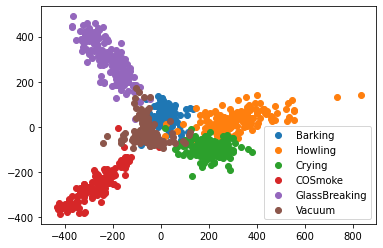

In [21]:
plot_cluster(X_train_np_hidden_2dim)

In [22]:
class_0_idx = [index for (index,value) in enumerate(y_valid_np) if value == 0]
class_1_idx = [index for (index,value) in enumerate(y_valid_np) if value == 1]
class_2_idx = [index for (index,value) in enumerate(y_valid_np) if value == 2]
class_3_idx = [index for (index,value) in enumerate(y_valid_np) if value == 3]
class_4_idx = [index for (index,value) in enumerate(y_valid_np) if value == 4]
class_5_idx = [index for (index,value) in enumerate(y_valid_np) if value == 5]

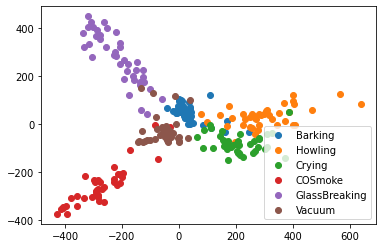

In [23]:
plot_cluster(X_valid_np_hidden_2dim)

In [24]:
from sklearn.preprocessing import StandardScaler
svm_clf = SVC(probability=True).fit(X_train_np_hidden_2dim,y_train_np)

In [25]:
y_true = y_valid_np
y_pred = svm_clf.predict(X_valid_np_hidden_2dim)
acc = accuracy_score(y_pred,y_true)
print(acc)
cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
cm.columns = list(map_dict.values())
cm

0.9125


,Barking,Howling,Crying,COSmoke,GlassBreaking,Vacuum
0,36,2,1,0,1,3
1,2,37,3,0,0,0
2,2,1,36,0,0,0
3,0,0,0,38,0,0
4,0,0,0,0,37,2
5,0,0,0,2,2,35


# 載入測試數據

In [26]:
X_test_np_hidden = get_X_numpy_backbone(X_test_all)
X_test_np_hidden_2dim = pca.transform(X_test_np_hidden)

100%|██████████| 157/157 [00:23<00:00,  6.68it/s]


In [27]:
final_prob = svm_clf.predict_proba(X_test_np_hidden_2dim)

In [28]:
final_prob.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [29]:
sample_submit = pd.read_csv('sample_submission.csv')
sample_submit.iloc[:10000,1:] = final_prob
sample_submit

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,0.031073,0.004952,0.003371,0.005254,0.463265,0.492085
1,public_00002,0.034664,0.003134,0.002461,0.003605,0.006553,0.949583
2,public_00003,0.766481,0.008365,0.004946,0.002295,0.004541,0.213372
3,public_00004,0.013611,0.003933,0.002769,0.012974,0.121507,0.845207
4,public_00005,0.389390,0.058935,0.318860,0.006911,0.004499,0.221404
...,...,...,...,...,...,...,...
29995,private_19996,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29996,private_19997,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29997,private_19998,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29998,private_19999,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000


In [30]:
acc

0.9125

In [31]:
sample_submit.to_csv(f'submit_valid_acc_{acc}.csv',index=False)
print('done')

done
